# モジュールをインポート

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# 学習歴史を読み込み

In [10]:
results_path = "keras_2020_01_18_16_28"
results_path = "./results/" + results_path 
with open(results_path + "/train_hist", "rb") as file:
    history = pickle.load(file)

In [11]:
history.keys()

dict_keys(['acc', 'val_acc', 'val_loss', 'loss'])

# 学習正解率を描画

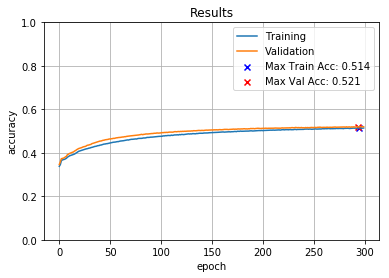

In [12]:
plt.plot(history['acc'], color="C0", label="Training")
plt.plot(history['val_acc'], color="C1", label="Validation")
max_val_index = np.argmax(history["acc"])
max_val = history["acc"][max_val_index]
# plt.annotate("Max Acc", xy=(max_val_index, history["val_acc"][max_val_index]), xycoords="data", label=("Max Val Acc: " + str(max_val.round(2))))
plt.scatter(max_val_index, history["acc"][max_val_index], marker="x", color="blue", label=("Max Train Acc: " + str(max_val.round(3))))
max_val_index = np.argmax(history["val_acc"])
max_val = history["val_acc"][max_val_index]
# plt.annotate("Max Acc", xy=(max_val_index, history["val_acc"][max_val_index]), xycoords="data", label=("Max Val Acc: " + str(max_val.round(2))))
plt.scatter(max_val_index, history["val_acc"][max_val_index], marker="x", color="red", label=("Max Val Acc: " + str(max_val.round(3))))
plt.title("Results")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.show()

# 学習損失を描画

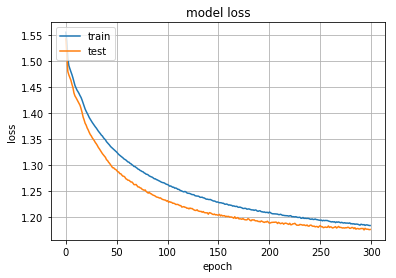

In [13]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

# 検証データセットを読み込み

In [27]:
dataset_dir = "./dataset/preprocessed_dataset/"
result_dir = "./results/"

with open(dataset_dir+"1_2_2x4_dataset_3D_win_10_normalize_False_overlap_False.pkl", "rb") as fp:
    X_valid = pickle.load(fp)
with open(dataset_dir+"1_2_2x4_label_3D_win_10_normalize_False_overlap_False.pkl", "rb") as fp:
    y_valid = pickle.load(fp)
X_valid = X_valid.reshape(-1, 10, 2, 4, 1)
print("Dataset shape:", X_valid.shape)
print("Labels shape:", y_valid.shape)

Dataset shape: (5861, 10, 2, 4, 1)
Labels shape: (5861,)


# ラベルエンコーディング

In [28]:
with open(results_path + "/ohe", "rb") as file:
    ohe = pickle.load(file)

In [29]:
y_valid = ohe.transform(y_valid.reshape(-1, 1))

In [30]:
y_valid

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [31]:
print("Test dataset shape:", X_valid.shape)
print("Test label shape:", y_valid.shape)

Test dataset shape: (5861, 10, 2, 4, 1)
Test label shape: (5861, 5)


# モデルを定義

In [19]:
from tensorflow.keras.models import load_model

In [20]:
model = load_model(results_path + "/model/model.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
dropout_prob = 0.5
n_labels = y_valid.shape[1]
training_epochs = 10
batch_size = 300
learning_rate = 1e-4

# モデルの確認

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 2, 4, 1)]     0         
_________________________________________________________________
conv3d (Conv3D)              (None, 10, 2, 4, 64)      128       
_________________________________________________________________
reshape (Reshape)            (None, 10, 512)           0         
_________________________________________________________________
dense (Dense)                (None, 10, 256)           131328    
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 512)           787968

In [33]:
# from contextlib import redirect_stdout

# with open('test.txt', 'w') as f:
#     with redirect_stdout(f):
#         model.summary()

# テストデータを分類

In [34]:
y_pred = model.predict(X_valid, batch_size=300, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

5861/5861 [==============================] - 1s 231us/sample


In [35]:
y_pred = ohe.inverse_transform(y_pred)

In [36]:
y_pred

array([['image_open&close_both_feet'],
       ['image_open&close_both_fists'],
       ['image_open&close_both_fists'],
       ...,
       ['image_open&close_both_feet'],
       ['image_open&close_both_feet'],
       ['image_open&close_both_feet']], dtype='<U32')

In [37]:
y_pred = ohe.transform(y_pred)

In [38]:
y_pred

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [39]:
y_valid

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

# 精度と正解率の曲線

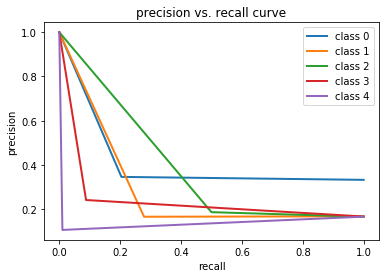

In [40]:
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

precision = dict()
recall = dict()
for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_valid[:, i],
                                                        y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

# 分類結果

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.20      0.26      1950
           1       0.17      0.28      0.21       984
           2       0.19      0.50      0.27       974
           3       0.24      0.09      0.13       978
           4       0.11      0.01      0.02       975

   micro avg       0.21      0.21      0.21      5861
   macro avg       0.21      0.22      0.18      5861
weighted avg       0.23      0.21      0.19      5861
 samples avg       0.21      0.21      0.21      5861



In [44]:
ohe.categories_

[array(['eye_close', 'image_open&close_both_feet',
        'image_open&close_both_fists', 'image_open&close_left_fist',
        'image_open&close_right_fist'], dtype='<U32')]

In [32]:
print("検証正解率：", history["val_acc"][-1])

検証正解率： 0.30514848


In [33]:
from sklearn.metrics import accuracy_score
print("テスト正解率：", accuracy_score(y_valid, y_pred))

テスト正解率： 0.3019947950293196


In [40]:
y_valid = ohe.inverse_transform(y_valid)
y_pred = ohe.inverse_transform(y_pred)

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

array([[27280,  5944,  5793,  7034,  6567],
       [ 7111,  4358,  4308,  4581,  3988],
       [ 7048,  4329,  4472,  4635,  3999],
       [ 7105,  4206,  4510,  5027,  4020],
       [ 7091,  3885,  4281,  4434,  4235]])